In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Load the data

In [2]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [3]:
y.shape, tx.shape

((10000,), (10000, 2))

The `tx` variable returned by `build_model_data()` stands for $\tilde X$, which is the feature matrix $X$ with an additional column $(1, \dots, 1)^\top$ to account for the offset $w_0$.

In [4]:
tx[:5, :]

array([[1.        , 1.94406149],
       [1.        , 0.62753668],
       [1.        , 2.01244346],
       [1.        , 1.39406046],
       [1.        , 0.9134207 ]])

# 1 Computing the Cost Function

* Model parameters $\mathbf{w} = [w_0,w_1]^\top$
* $\mathbf{e}=\mathbf{y}-\mathbf{\tilde X w}$


We want to compute the MSE in terms of the vector $\mathbf{e}$:

$$\begin{align}
\mathcal{L}(\mathbf{w}) &= \frac{1}{N}\sum_{n=1}^N \left(y_n - \mathbf{\tilde x_n}^\top \mathbf{w}\right)^2 \\
&= \frac{1}{N}\sum_{n=1}^N e_n^2 \\
&= \frac{1}{N} \lVert \mathbf{e} \rVert ^2 \\ 
&= \frac{1}{N} \mathbf{e}^\top\mathbf{e}
\end{align}$$

Fill in the `compute_loss` function below:
<a id='compute_loss'></a>


In [5]:
def compute_loss(y, tx, w):
    """Calculate the loss.

    You can calculate the loss using mse or mae.
    """
    e = y - np.matmul(tx, w)
    return np.inner(e, e) / len(y)

In [6]:
w = np.array([1,2])
print(w.shape)
print(w)
compute_loss(y, tx, w)

(2,)
[1 2]


5388.966731774169

Note that we should not instanciate `w` as a column vector (i.e. numpy array with shape `(2, 1)`) if we keep `y` as a 1D array. We should basically consider that numpy 1D arrays act as column vectors. 

# 2 Grid Search

Fill in the function `grid_search()` below:

In [7]:
def grid_search(y, tx, w0, w1):
    """Algorithm for grid search."""
    # Numpy trick: use meshgrid to simulate for loops
    # w_grid = np.stack(np.meshgrid(w0, w1), axis=2)
    # TODO: find a way to apply over axes 0 and 1
    # losses = w_grid.apply()
    nrow, ncol = len(w0), len(w1)
    losses = np.zeros((nrow, ncol))
    for i in range(nrow):
        for j in range(ncol):
            losses[i, j] = compute_loss(y, tx, np.array([w0[i], w1[j]]))
    return losses

Let us play with the grid search demo now!

Grid Search: loss*=84.84896629356496, w0*=66.66666666666669, w1*=16.666666666666686, execution time=0.003 seconds


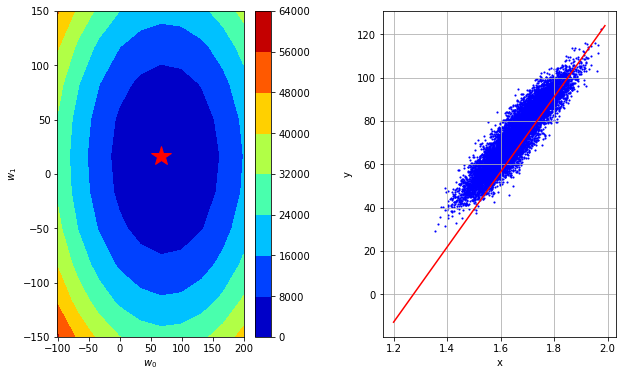

In [8]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization

# Generate the grid of parameters to be swept
grid_w0, grid_w1 = generate_w(num_intervals=10)

# Start the grid search
start_time = datetime.datetime.now()
grid_losses = grid_search(y, tx, grid_w0, grid_w1)

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()

# Print the results
print("Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
      l=loss_star, w0=w0_star, w1=w1_star, t=execution_time))

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
fig.set_size_inches(10.0,6.0)
plt.subplots_adjust(wspace=.4)
fig.savefig("grid_plot")  # Optional saving

The estimate does not seem good, since we only used 10 values per dimension for $\mathbf{w}$. Let's repeat the process for 200 values per dimension:

Grid Search: loss*=31.220171304977598, w0*=73.36683417085428, w1*=12.8140703517588, execution time=1.214 seconds


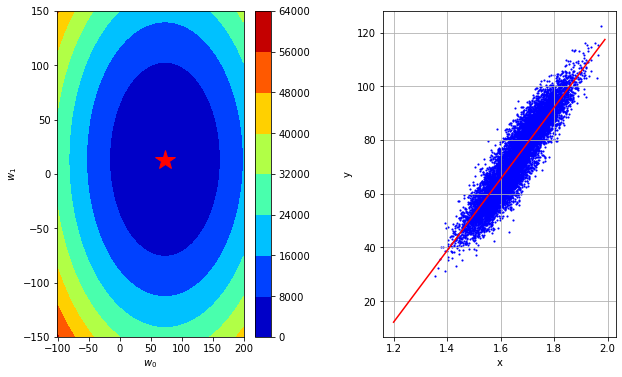

In [9]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization

# Generate the grid of parameters to be swept
grid_w0, grid_w1 = generate_w(num_intervals=200)

# Start the grid search
start_time = datetime.datetime.now()
grid_losses = grid_search(y, tx, grid_w0, grid_w1)

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()

# Print the results
print("Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
      l=loss_star, w0=w0_star, w1=w1_star, t=execution_time))

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
fig.set_size_inches(10.0,6.0)
plt.subplots_adjust(wspace=.4)
fig.savefig("grid_plot")  # Optional saving

Which looks much better!

# 3 Gradient Descent

Again, please fill in the functions `compute_gradient` below:

Given the MSE and a linear model:

$$\begin{align}
\mathcal{L}(\mathbf{w}) &= -\frac{1}{N}\textstyle\sum_{n=1}^N \mathcal{L}_n(\mathbf{w}) \\
\mathcal{L}_n(\mathbf{w}) &= \left(y_n - f(\mathbf{x}_n) \right)^2 \\
f(\mathbf{x}_n) &= \mathbf{\tilde x}_n^\top \mathbf{w}
\end{align}$$

we get the gradient (in the case $p=2$):

$$\begin{align}
\nabla \mathcal{L}(\mathbf{w}) &= 
\begin{bmatrix}
\frac{\partial \mathcal{L}}{\partial w_0} (\mathbf{w}) \\
\frac{\partial \mathcal{L}}{\partial w_1} (\mathbf{w})
\end{bmatrix}
= \begin{bmatrix}
-\frac{1}{N}\textstyle\sum_{n=1}^N e_n \\
-\frac{1}{N}\textstyle\sum_{n=1}^N e_n x_{n1}
\end{bmatrix}
= -\frac{1}{N} \tilde X^\top \mathbf{e}
\end{align}$$

In [10]:
def compute_gradient(y, tx, w):
    """Compute the gradient."""
    e = y - np.dot(tx, w)
    return - np.dot(tx.T, e) / len(y)

In [11]:
# Check function output with values easily computable by hand
ytest = np.array([-1, 1])
tXtest = np.array([[1, 3], [1, 2]])
wtest = np.array([1, 2])
assert np.all(compute_gradient(ytest, tXtest, wtest) == [6., 16.])

We compute the gradient for:

* $\mathbf{w}=[100, 20]^\top$
* $\mathbf{w}=[50, 10]^\top$

With grid search, we found that $w_0^\star \approx 73, w_1^\star \approx 13$.

In [12]:
np.linalg.norm(compute_gradient(y, tx, [100, 20]))

27.49052112929252

In [13]:
np.linalg.norm(compute_gradient(y, tx, [50, 10]))

23.55239267824773

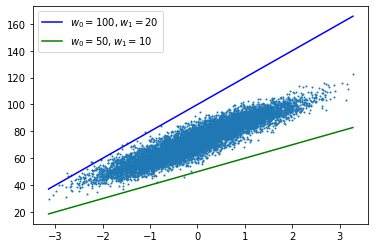

In [14]:
plt.scatter(tx[:, 1], y, s=1)
xgrid = np.linspace(tx[:, 1].min(), tx[:, 1].max(), 100)
plt.plot(xgrid, 100 + 20*xgrid, 'b', label=r'$w_0=100, w_1=20$')
plt.plot(xgrid, 50 + 10*xgrid, 'g', label='$w_0=50, w_1=10$')
plt.legend();

The norm of the gradient of the loss function $\mathcal L$ is slightly higher for the blue curve.

Please fill in the functions `gradient_descent` below:

In [15]:
def gradient_descent(y, tx, initial_w, max_iters, gamma, verbose=True):
    """Gradient descent algorithm."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # Compute gradient and loss
        loss = compute_loss(y, tx, w)
        grad = compute_gradient(y, tx, w)
        # Update model parameters
        w = w - gamma * grad
        # Store and print
        ws.append(w)
        losses.append(loss)
        if verbose:
            print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
                  bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))

    return losses, ws

Test your gradient descent function through gradient descent demo shown below:

In [16]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()
gradient_losses, gradient_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Gradient Descent: execution time={t:.3f} seconds".format(t=exection_time))

Gradient Descent(0/49): loss=5584.473425518336, w0=51.30574540147362, w1=9.435798704492251
Gradient Descent(1/49): loss=530.6049242179207, w0=66.69746902191571, w1=12.266538315839991
Gradient Descent(2/49): loss=75.75675910088256, w0=71.31498610804834, w1=13.115760199244328
Gradient Descent(3/49): loss=34.82042424034894, w0=72.70024123388814, w1=13.370526764265632
Gradient Descent(4/49): loss=31.136154102900914, w0=73.11581777164007, w1=13.446956733772023
Gradient Descent(5/49): loss=30.80456979053059, w0=73.24049073296565, w1=13.469885724623941
Gradient Descent(6/49): loss=30.77472720241726, w0=73.27789262136334, w1=13.476764421879516
Gradient Descent(7/49): loss=30.77204136948706, w0=73.28911318788263, w1=13.478828031056189
Gradient Descent(8/49): loss=30.77179964452334, w0=73.29247935783842, w1=13.47944711380919
Gradient Descent(9/49): loss=30.771777889276603, w0=73.29348920882516, w1=13.47963283863509
Gradient Descent(10/49): loss=30.7717759313044, w0=73.29379216412119, w1=13.47968

In [17]:
# Time Visualization
from ipywidgets import IntSlider, interact

def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gradient_losses, gradient_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gradient_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

## Try different configurations



In [18]:
def plot_losses(losses, varname, print_last=True):
    for val, ls in losses.items():
        plt.semilogy(ls, '--', label=f'{varname}={val}')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    if print_last:
        for val, ls in losses.items():
            print(val, '\t', ls[-1])

### Step size $\gamma$ selection

0.001 	 5065.78240211379
0.01 	 2104.880966230689
1 	 30.7717757376588
2 	 5584.47342551816
2.5 	 1.0035197699617528e+21


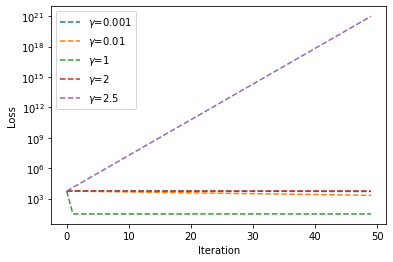

In [19]:
# Vary gamma
w_init = [0, 0]
max_iters = 50
losses = {
    gamma: gradient_descent(y, tx, w_initial, max_iters, gamma, verbose=False)[0]
    for gamma in [0.001, 0.01, 1, 2, 2.5]
}
plot_losses(losses, '$\gamma$')


The stepsize hyperparameter $\gamma$ is **critical for the convergence** of the gradient descent algorithm.

### Initial value selection

(0, 0) 	 30.793916810421397
(100, 10) 	 30.7746673998954
(-1000, 1000) 	 39.24428919576174


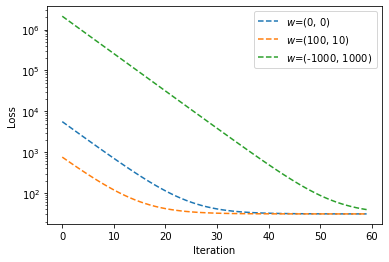

In [20]:
# Vary w_init
gamma = 0.1
max_iters = 60
losses = {
    w_init: gradient_descent(y, tx, w_init, max_iters, gamma, verbose=False)[0]
    for w_init in [(0,0), (100, 10), (-1000, 1000)]
}
plot_losses(losses, '$w$')

Given a good enough $\gamma$, $\mathbf{w}^{(0)}$ is not critical for convergence for the gradient descent algorithm with MSE on a linear model. 

# 4 Stochastic gradient descent

In [21]:
def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient from just few examples n and their corresponding y_n labels."""
    e = y - np.dot(tx, w)
    return - np.dot(tx.T, e) / len(y)


def stochastic_gradient_descent(
        y, tx, initial_w, batch_size, max_iters, gamma):
    """Stochastic gradient descent algorithm."""
    losses = []
    ws = [initial_w]
    w = initial_w
    for batch_y, batch_tx in batch_iter(y, tx, batch_size=batch_size, num_batches=max_iters):
        # Compute
        loss = compute_loss(batch_y, batch_tx, w)
        grad = compute_stoch_gradient(batch_y, batch_tx, w)
        # Update
        w = w - gamma * grad
        # Store
        losses.append(losses)
        ws.append(w)
        
    
    return losses, ws

In [22]:
# from stochastic_gradient_descent import *

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7
batch_size = 5

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD: execution time=0.001 seconds


Note that it took $0.035$ s for the full gradient descent. 

In [23]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses, sgd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gradient_ws)));

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

# 5 Effect of Outliers

### Exercise 5


In [24]:
height, weight, gender = load_data(sub_sample=True)

In [25]:
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

We choose $\mathbf{x}^{(0)}$ and $\gamma$ such that gradient descent converges, according to previous results:

In [26]:
# Compute parameters of linear model
gamma = 0.7
w_init = [50, 10]
losses, ws = gradient_descent(y, tx, w_init, 40, gamma, verbose=False)
w = ws[-1]
print(losses[-1], w)

27.286869623045312 [73.63227246 14.47570488]


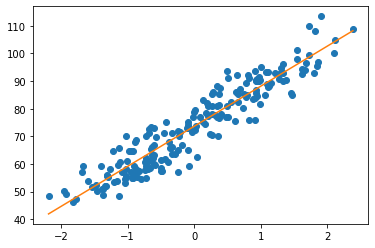

In [27]:
xgrid = np.linspace(x.min(), x.max(), 100)
plt.plot(x, weight, 'o')
plt.plot(xgrid, w[0] + w[1] * xgrid);

In [28]:
height, weight, _ = load_data(sub_sample=True, add_outlier=True)
x, _, _ = standardize(height)
y, tx = build_model_data(x, weight)

In [29]:
losses, ws = gradient_descent(y, tx, [50, 10], max_iters=50, gamma=0.7, verbose=False)
w_outliers = ws[-1]

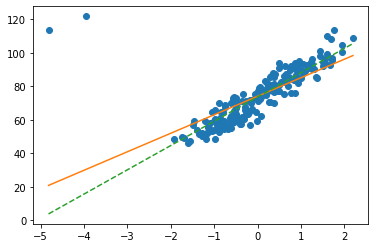

In [30]:
xgrid = np.linspace(x.min(), x.max(), 100)
plt.plot(x, weight, 'o', xgrid, w_outliers[0] + w_outliers[1] * xgrid);
plt.plot(xgrid, w[0] + w[1] * xgrid, '--')

The orange regression line has quiet a bit changed compared to the green regression line (the one obtained without outliers). This is because the **MSE isn't robust against outliers**.

# 6 Subgradient Descent

### Exercise 6

Modify the function `compute_loss(y, tx, w)` for the Mean Absolute Error cost function [here](#compute_loss)

In [31]:
def compute_loss(y, tx, w, which='mse'):
    e = y - np.matmul(tx, w)
    if which == 'mse':
        return np.inner(e, e) / len(y)
    elif which == 'mae':
        return np.abs(e).sum() / len(y)
    
    raise ValueError

Now we must write `compute_subgradient`. We note that:

* if $\mathcal{L}$ is convex and differentiable at $\mathbf{w}$, the subgradient $\mathbf{g}$ is unique: $\mathbf{g} = \nabla\mathcal{L}(\mathbf{w})$

Using the chain rule for the subgradient:

$$\begin{align}
\mathcal{L}(\mathbf{w}) &= h(q(\mathbf{w})), \text{with } q \text{ differentiable} \\
\Rightarrow \partial \mathcal{L}(\mathbf{w}) &= \partial h(q(\mathbf{w})) \, \nabla q(\mathbf{w})
\end{align}$$

where $\partial h$ denotes the **set of all possible subgradients** of $h$ at $q(\mathbf{w})$. We write:

$$
h(\mathbf{w}) = \frac{1}{N}\textstyle\sum_{n=1}^N |q_n(\mathbf{w})|, \qquad q_n(\mathbf{w}) = y_n - f_\mathbf{w}(\mathbf{x_n}) = e_n 
$$

from which we obtain 

$$\nabla q_n(\mathbf{w}) = \begin{bmatrix}
-1\\
-\tilde X_{n1}
\end{bmatrix}$$

Now the only problem is that $h$ is *not* differentiable whenever $\exists n$ such that $q_n(\mathbf{w}) = 0$, or equivalently $y_n = f_\mathbf{w}(\mathbf{x}_n)$, since the function $|\cdot|$ is not differentiable at 0. In that case, the subgradient can take any value in $[-1, 1]$. We arbitrarily choose to set the subgradient to 0 in such cases (but it makes sense, since the error $e_n=0$, the cost associate with data point $\mathbf{x}_n$ should be zero).

As an implementation consideration, we can use the function `np.sign` instead of relying on a logical mask to fill in values $\in \{-1,0,1\}$.

In [32]:
def compute_subgradient(y, tx, w):
    e = y - np.dot(tx, w)
    subgradient_abs = np.sign(e)
    return - np.dot(tx.T, subgradient_abs) / len(y)

In [33]:
def subgradient_descent(y, tx, w_init, n_iter, gamma, verbose=False):
    losses = []
    ws = [w_init]
    w = w_init
    for k in range(n_iter):
        loss = compute_loss(y, tx, w, which='mae')
        subgradient = compute_subgradient(y, tx, w)
        # Update
        w = w - gamma * subgradient
        # Store
        losses.append(loss)
        ws.append(w)
        if verbose:
            print(f'{k}:\tw={w},\tloss={loss}')
    
    return losses, ws

In [45]:
height, weight, _ = load_data(sub_sample=True, add_outlier=False)
x, _, _ = standardize(height)
y, tx = build_model_data(x, weight)

In [46]:
losses, ws = subgradient_descent(y, tx, [0,0], n_iter=100, gamma=1.2, verbose=False)
w = ws[-1]

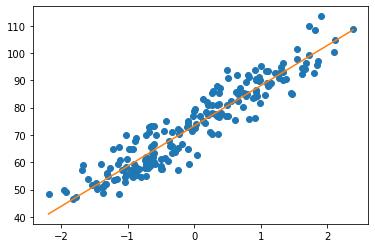

In [47]:
plt.plot(x, y, 'o')
xgrid = np.linspace(x.min(), x.max(), 100)
plt.plot(xgrid, w[0] + w[1] * xgrid);

In [48]:
height, weight, _ = load_data(sub_sample=True, add_outlier=True)
x, _, _ = standardize(height)
y, tx = build_model_data(x, weight)

In [49]:
losses, ws = subgradient_descent(y, tx, [0,0], n_iter=100, gamma=1.2, verbose=False)
w_outliers = ws[-1]

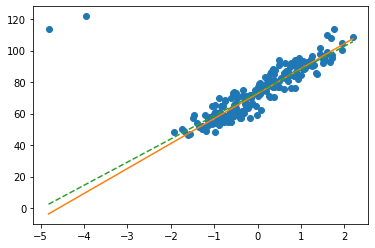

In [50]:
plt.plot(x, y, 'o')
xgrid = np.linspace(x.min(), x.max(), 100)
plt.plot(xgrid, w_outliers[0] + w_outliers[1] * xgrid)
plt.plot(xgrid, w[0] + w[1] * xgrid, '--')